### 3.2 코드 어시스트 챗봇

- 코파일럿과 유사한 코드를 생성하여 개발을 도와주는 챗봇을 구현하겠습니다.


1. 사용자가 질문과 함께 코드 맥락을 제공합니다.
2. 제공된 코드 맥락을 분석하고, 이를 바탕으로 질문에 대한 답변을 생성합니다.
3. 구조화된 출력을 생성하기 위해 필요한 도구를 호출합니다.
4. 사용자에게 최종 답변을 반환하기 전에 두 가지 단위테스트(임포트와 코드 실행)를 수행합니다.


- 문서 정의
- LLM에 제공할 코드 관련 문서를 정의하겠습니다. 랭체인 LECL 공식 문서를 가져와 코드 맥락으로 제공합니다.


In [17]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# 크롤링할 URL 지정
url = "https://python.langchain.com/v0.2/docs/concepts/#langchain-ex[ression-language-lcel"
# 해당 페이지를 재귀적으로 크롤링
loader = RecursiveUrlLoader(
    url=url,
    max_depth=20,  # 최대 깊이 설정
    extractor=lambda x: Soup(x, "html.parser").text,
)

# 지정된 URL에서 크롤링한 문서를 'docs' 변수에 저장
docs = loader.load()

# 크롤링된 문서를 'source' 메타데이터를 기준으로 정렬
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# 모든 문서의 내용을 하나의 문자열로 연결
concatenated_text = "\n\n\n --- \n\n\n".join([doc.page_content for doc in d_reversed])
concatenated_text

'\n\n\n\n\nConceptual guide | \uf8ffü¶úÔ∏è\uf8ffüîó LangChain\n\n\n\n\n\n\n\nSkip to main contentA newer LangChain version is out! Check out the latest version.IntegrationsAPI referenceLatestLegacyMorePeopleContributingCookbooks3rd party tutorialsYouTubearXivv0.2Latestv0.2v0.1\uf8ffü¶úÔ∏è\uf8ffüîóLangSmithLangSmith DocsLangChain HubJS/TS Docs\uf8ffüí¨SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a Simple LLM Application with LCELBuild a Query Analysis SystemBuild a ChatbotConversational RAGBuild an Extraction ChainBuild an AgentTaggingdata_generationBuild a Local RAG ApplicationBuild a PDF ingestion and Question/Answering systemBuild a Retrieval Augmented Generation (RAG) AppVector stores and retrieversBuild a Question/Answering system over SQL dataSummarize TextHow-to guidesHow-to guidesHow to use tools in a chainHow to use a vectorstore as a retrieverHow to add memory to chatbotsHow to use example selectorsHow to map values to a

- RecursiveUrlLoader은 지정한 URL을 기준으로 하위 페이지까지 재귀적으로 크롤링 하며, BeautifulSoup을 사용해 페이지에서 텍스트만 추출합니다.
- 수집한 문서들은 코드 생성과 관련된 질문에 답변할 때 참고하는 맥락으로 제공됩니다.


- 코드생성


In [18]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

# LLM이 LCEL 전문가로서 사용자의 질문에 답변하도록 지시하는 프롬프트 정의
system = """
당신은 LCEL(LangChain Expression Language) 전문가인 코딩 어시스턴트입니다.
다음은 필요한 LCEL 문서의 전문입니다:
-------
{context}
-------
위에 제공된 문서를 기반으로 사용자 질문에 한국어로 답변하세요.
제공하는 코드는 실행 가능해야 하며, 필요한 모든 import 문과 변수들이 정의되어 있어야 합니다.
답변을 다음과 같은 구조로 작성하세요:
1. prefix: 문제와 접근 방식에 대한 설명
2. imports: 코드 블록 import 문
3. code: import 문을 제외한 코드 블록
4. description: 질문에 대한 코드 스키마

다음은 사용자 질문입니다:
"""

# 시스템 메시지와 사용자의 질문을 포함한 템플릿 작성
code_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", system), ("placeholder", "{message}")]
)


# 코드 출력을 구조화하기 위한 데이터 모델 정의
class code(BaseModel):
    prefix: str = Field(description="문제와 접근 방식에 대한 설명")
    imports: str = Field(description="코드 블록 import 문")
    code: str = Field(description="import 문을 제외한 코드 블록")
    description: str = Field(description="질문에 대한 코드 스키마")


# 코드 생성을 위한 LLM 정의
llm = ChatOpenAI(model="gpt-4o", temperature=0.0)

# 프롬프트, 구조화된 LLM 출력을 결합하여 RAG 체인 생성
code_gen_chain = code_gen_prompt | llm.with_structured_output(code)


In [19]:
question = "LCEL로 RAG 체인을 어떻게 만들 수 있나요?"
solution = code_gen_chain.invoke(
    {"context": concatenated_text, "messages": [("user", question)]}
)
print(solution)

prefix='LangChain Expression Language(LCEL)을 사용하여 LangChain 구성 요소를 체인으로 연결하는 방법을 설명합니다. LCEL은 LangChain 구성 요소를 선언적으로 연결할 수 있는 방법을 제공합니다. 이를 통해 프로토타입을 코드 변경 없이 프로덕션에 배포할 수 있습니다.' imports='from langchain_core.prompts import PromptTemplate\nfrom langchain_anthropic import ChatAnthropic\nfrom langchain_core.output_parsers import StrOutputParser' code='# Define a prompt template\nprompt_template = PromptTemplate.from_template("Tell me a joke about {topic}")\n\n# Initialize a chat model\nmodel = ChatAnthropic(model="claude-3-sonnet-20240229")\n\n# Define an output parser\nparser = StrOutputParser()\n\n# Chain the components together\nchain = prompt_template | model | parser\n\n# Invoke the chain with a specific topic\nresult = chain.invoke({"topic": "cats"})\nprint(result)' description="이 코드는 LCEL을 사용하여 프롬프트 템플릿, 채팅 모델, 출력 파서를 체인으로 연결하는 예제입니다. 'cats'라는 주제로 농담을 생성하도록 체인을 구성하고, 최종 결과를 출력합니다. LCEL을 사용하면 이러한 구성 요소를 선언적으로 연결하여 복잡한 체인을 쉽게 만들 수 있습니다."


- 상태


In [20]:
from typing import List, TypedDict


class GraphState(TypedDict):
    error: str
    messages: List
    generation: str
    iterations: int

- error: 테스트 오류가 발생했는지 여부
- messages: 사용자의 질문, 오류 메시지, 이유 등을 포함하는 메시지목록
- generation: 생성된 코드
- iterations: 시도 횟수


- 그래프
- 사용자의 질문에 따라 코드를 생성하고, 자동으로 테스트를 진행하여 검증까지 합니다.
- 파이썬의 exec() 함수는 문자열로 구성된 파이썬 코드를 실행하는 함수이므로 실행하여 오류여부를 확인할 수 있습니다.


In [22]:
def generate(state: GraphState):
    """
    코드를 생성합니다.

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        state (dict): 생성한 코드가 업데이트된 상태
    """
    print("---코드 생성---")

    messages = state["messages"]
    iterations = state["iterations"]
    error = state.get("error", "no")

    if error == "yes":
        messages += [
            (
                "user",
                "다시 시도해보세요. 출력 결과를 prefix, imports, code block으로 구조화하기 위해 코드 도구를 호출하세요:",
            )
        ]

    code_solution = code_gen_chain.invoke(
        {"context": concatenated_text, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]
    iterations += 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState):
    """
    코드 검사

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        state (dict): 오류 여부가 업데이트된 상태
    """
    print("---코드 검사---")

    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    imports = code_solution.imports
    code = code_solution.code

    try:
        exec(imports)
    except Exception as e:
        print("---import 체크: 실패---")
        error_message = [("user", f"당신의 코드는 import 테스트를 실패했습니다: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---code block 체크: 실패---")
        error_message = [("user", f"당신의 코드는 실행 테스트를 실패했습니다: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    print("---오류 없음---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }


def reflect(state: GraphState):
    """
    오류 반영

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        state (dict): 생성된 코드가 추가된 상태
    """
    print("---코드 솔루션 생성---")

    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    reflections = code_gen_chain.invoke(
        {"context": concatenated_text, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"여기 오류를 반영한 코드입니다: {reflections}",
        )
    ]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


- 에지 메서드 구현
- 최대 횟수 3회에 도달하면 종료하고, 그렇지 않으면 재시도합니다.


In [23]:
flag = "do not reflect"


def decide_to_finish(state: GraphState):
    """
    종료 여부를 결정합니다.

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        str: 다음에 호출할 노드
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == 3:
        print("---종료---")
        return "end"
    else:
        print("---다시 시도---")
        if flag is True:
            return "reflect"
        else:
            return "generate"


In [24]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("generate", generate)
workflow.add_node("code_check", code_check)
workflow.add_node("reflect", reflect)

# 그래프 정의
workflow.add_edge(START, "generate")
workflow.add_edge("generate", "code_check")
workflow.add_conditional_edges(
    "code_check",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")

# 그래프 컴파일
app = workflow.compile()

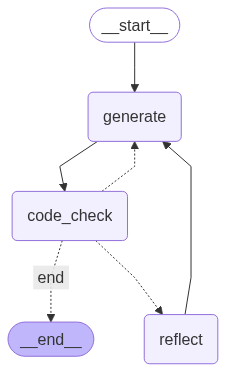

In [15]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [25]:
question = "문자열을 runnable 객체에 직접 전달하고, 이를 사용하여 내 프롬프트에 필요한 입력을 구성하려면 어떻게 해야 하나요?"
app.invoke({"messages": [("user", question)], "iterations": 0})

---코드 생성---
---코드 검사---
---import 체크: 실패---
---다시 시도---
---코드 생성---
---코드 검사---
---import 체크: 실패---
---다시 시도---
---코드 생성---
---코드 검사---
---import 체크: 실패---
---종료---


{'error': 'yes',
 'messages': [('user',
   '문자열을 runnable 객체에 직접 전달하고, 이를 사용하여 내 프롬프트에 필요한 입력을 구성하려면 어떻게 해야 하나요?'),
  ('assistant',
   'LangChain Expression Language(LCEL)을 사용하여 LangChain 구성 요소를 체인으로 연결하는 방법을 설명합니다. LCEL은 LangChain 구성 요소를 선언적으로 연결할 수 있는 방법을 제공합니다. 이를 통해 프로토타입을 코드 변경 없이 프로덕션에 배포할 수 있습니다. \n Imports: from langchain_core.prompts import PromptTemplate\nfrom langchain_anthropic import ChatAnthropic\nfrom langchain_core.output_parsers import StrOutputParser \n Code: # Define a prompt template\nprompt_template = PromptTemplate.from_template("Tell me a joke about {topic}")\n\n# Initialize a chat model\nmodel = ChatAnthropic(model="claude-3-sonnet-20240229")\n\n# Define an output parser\nparser = StrOutputParser()\n\n# Chain the components together\nchain = prompt_template | model | parser\n\n# Invoke the chain with a specific topic\nresult = chain.invoke({"topic": "cats"})\nprint(result)'),
  ('user',
   "당신의 코드는 import 테스트를 실패했습니다: No module named 'langchain_anthropic'"),
  (